## Instalación

In [ ]:
# Installation of a library that allows connection to a GitHub repository
# ==============================================================================
!pip install gitpython

# https://www.kaggle.com/code/igones/eda-store-sales-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


## Importación

In [ ]:
# Data processing
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime
import tabulate
from scipy import stats

# Acces to GitHub
# ==============================================================================
import git
import shutil
import os
import requests
import zipfile
import io
from io import BytesIO

# Math and statistics functions
# ==============================================================================
import math

# Data preparation
# ==============================================================================
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # Análisis de Componentes Principales

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px

# PCA
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # Análisis de Componentes Principales
from sklearn.decomposition import KernelPCA # Kernel PCA
from sklearn.decomposition import SparsePCA # PCA esparcido
from sklearn.decomposition import MiniBatchSparsePCA # Mini Batch PCA esparcido
from sklearn.utils.extmath import safe_sparse_dot # Producto punto entre matrices esparcidos para SparsePCA.
from sklearn.decomposition import IncrementalPCA # PCA incremental
from sklearn.decomposition import FastICA # Análisis de Componentes Independientes
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection, SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE # TSNE

# Separación de datos
# ==============================================================================
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

# Regresión lineal
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Se llama a una clase llamada mean_absolute_error, el cual es
from sklearn.metrics import mean_absolute_error

#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#Creación de modelo
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

#Modelo XGB
from xgboost import XGBRegressor
import xgboost as xgb

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
import matplotlib.pyplot as plt

# Modelos
# ==============================================================================

from scipy.stats import pearsonr
from scipy import stats

#Series de tiempo
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #estacionariedad
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')



##Functions

This part of the code will have functions created for the project.

In [ ]:
def extra_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['day_week'] = df['date'].dt.weekday
    df['weekmonth'] = (df['day'] - 1) // 7 + 1
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['payment'] = df['date'].agg(lambda x: 1 if x.day==15 else 1 if x == x.days_in_month else 0)
    return df

In [ ]:
# Función para convertir una matriz de correlación de pandas en formato tidy:
#
# corr_mat  : Matriz de correlación
#
# Ejemplos:
#    tidy_corr_matrix(corr_mat)
# ==============================================================================
def tidy_corr_matrix(corr_mat):

    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

In [ ]:
# Función para calcular el RMSLE (Root Mean Squared Logarithmic Error):
#
# predicted  : Array que contiene los valores predichos por el modelo
# actual     : Array con los valores reales
#
# Ejemplos:
#    rmsle([2,8,7], [3,5,12]])
# ==============================================================================
def RMSLE(predicted, actual):
    # Apply logarithm to predicted and actual values
    predicted_log = np.log1p(predicted)
    actual_log = np.log1p(actual)

    # Calculate the squared differences between predicted and actual logarithmic values
    squared_diff = (predicted_log - actual_log) ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the RMSLE by taking the square root of the mean squared difference
    RMSLE_resultado = np.sqrt(mean_squared_diff)
    return RMSLE_resultado

## Reading the data from the repository

In this part, we will use the connection to our repository so we can access to the necesary information needed to run the notebook.

In [ ]:
#URL Repository
url_repository = "https://github.com/fdofrancoc/MonografiaEspecializacionAnaliticaYCienciaDatos/blob/main/store-sales-time-series-forecasting.zip?raw=true"

response_repository = requests.get(url_repository)

if response_repository.status_code == 200:
  zip_ref = zipfile.ZipFile(io.BytesIO(response_repository.content), 'r')

  # List all the files in the ZIP file
  file_list = zip_ref.namelist()

  holiday_events = pd.read_csv(zip_ref.open(file_list[0]))
  oil = pd.read_csv(zip_ref.open(file_list[1]))
  sample_submission = pd.read_csv(zip_ref.open(file_list[2]))
  stores = pd.read_csv(zip_ref.open(file_list[3]))
  test = pd.read_csv(zip_ref.open(file_list[4]))
  train = pd.read_csv(zip_ref.open(file_list[5]))
  transactions = pd.read_csv(zip_ref.open(file_list[6]))

else:
    print(f"Failed to download file. Status code: {response_repository.status_code}")

In [ ]:
# Renombrar variables
oil.rename(columns={"dcoilwtico": "oil_price"},inplace = True)
stores.rename(columns={"city": "city_store","state":"state_store","type":"type_store","cluster":"cluster_store"},inplace = True)
holiday_events.rename(columns={"type":"type_day","locale":"type_holiday"},inplace = True)

In [ ]:
# Agrupamiento de la BD
train_merged = pd.merge(train, stores,how='left', on ='store_nbr')
train_merged = pd.merge(train_merged, holiday_events,how='left', on ='date')
train_merged = pd.merge(train_merged, oil,how='left', on ='date')
train_merged = pd.merge(train_merged, transactions,how='left', on =['date','store_nbr'])

In [ ]:
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,type_day,type_holiday,locale_name,description,transferred,oil_price,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN


In [ ]:
# Aplicación de la función extra_features
train_merged = extra_features(train_merged)

In [ ]:
# se selecciona la familia GROCERY ya que esta representa el mayor numero ventas.
train_merged = train_merged[train_merged['family'] == 'GROCERY I']

In [ ]:
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,...,description,transferred,oil_price,transactions,day,day_week,weekmonth,month,year,payment
12,12,2013-01-01,1,GROCERY I,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
45,45,2013-01-01,10,GROCERY I,0.0,0,Quito,Pichincha,C,15,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
78,78,2013-01-01,11,GROCERY I,0.0,0,Cayambe,Pichincha,B,6,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
111,111,2013-01-01,12,GROCERY I,0.0,0,Latacunga,Cotopaxi,C,15,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
144,144,2013-01-01,13,GROCERY I,0.0,0,Latacunga,Cotopaxi,C,15,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0


## Procesamiento

In [ ]:
# Cantidad de valores nulos
train_merged.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city_store           0
state_store          0
type_store           0
cluster_store        0
type_day         77328
type_holiday     77328
locale_name      77328
description      77328
transferred      77328
oil_price        28944
transactions      7549
day                  0
day_week             0
weekmonth            0
month                0
year                 0
payment              0
dtype: int64

In [ ]:
# Renombra datos que aparecen como nulos
train_merged['type_day'].replace(to_replace=np.nan, value='Normal', inplace=True)
train_merged['type_holiday'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['locale_name'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['description'].replace(to_replace=np.nan, value='Normal day', inplace=True)
train_merged['transferred'].replace(to_replace=np.nan, value='None', inplace=True)

# Toma el precio del petroleo del dia anterior y se elimina los datos nulos de la columna transacciones
train_merged['oil_price'].fillna(method="ffill", inplace = True)
train_merged.dropna(inplace = True)
# train_merged = train_merged.loc[train_merged['type_holiday']!='None']

In [ ]:
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,...,description,transferred,oil_price,transactions,day,day_week,weekmonth,month,year,payment
1794,1794,2013-01-02,1,GROCERY I,2652.0,0,Quito,Pichincha,D,13,...,Normal day,None,93.14,2111.0,2,2,1,1,2013,0
1827,1827,2013-01-02,10,GROCERY I,2579.0,0,Quito,Pichincha,C,15,...,Normal day,None,93.14,1293.0,2,2,1,1,2013,0
1860,1860,2013-01-02,11,GROCERY I,7736.0,0,Cayambe,Pichincha,B,6,...,Normal day,None,93.14,3547.0,2,2,1,1,2013,0
1893,1893,2013-01-02,12,GROCERY I,2677.0,0,Latacunga,Cotopaxi,C,15,...,Normal day,None,93.14,1362.0,2,2,1,1,2013,0
1926,1926,2013-01-02,13,GROCERY I,2587.0,0,Latacunga,Cotopaxi,C,15,...,Normal day,None,93.14,1102.0,2,2,1,1,2013,0


In [ ]:
# Cantidad de valores nulos
train_merged.isnull().sum()

id               0
date             0
store_nbr        0
family           0
sales            0
onpromotion      0
city_store       0
state_store      0
type_store       0
cluster_store    0
type_day         0
type_holiday     0
locale_name      0
description      0
transferred      0
oil_price        0
transactions     0
day              0
day_week         0
weekmonth        0
month            0
year             0
payment          0
dtype: int64

In [ ]:
# Información de la BD "organizada"
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85006 entries, 1794 to 3054327
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             85006 non-null  int64         
 1   date           85006 non-null  datetime64[ns]
 2   store_nbr      85006 non-null  int64         
 3   family         85006 non-null  object        
 4   sales          85006 non-null  float64       
 5   onpromotion    85006 non-null  int64         
 6   city_store     85006 non-null  object        
 7   state_store    85006 non-null  object        
 8   type_store     85006 non-null  object        
 9   cluster_store  85006 non-null  int64         
 10  type_day       85006 non-null  object        
 11  type_holiday   85006 non-null  object        
 12  locale_name    85006 non-null  object        
 13  description    85006 non-null  object        
 14  transferred    85006 non-null  object        
 15  oil_price     

In [ ]:
# variables dummies para la columna state_store
state_store_dummies= pd.get_dummies(train_merged['state_store']).add_prefix('state_store__')
train_merged[state_store_dummies.columns] = state_store_dummies.copy()

In [ ]:
# variables dummies para la columna cluster_store
cluster_store_dummies= pd.get_dummies(train_merged['cluster_store']).add_prefix('cluster_store__')
train_merged[cluster_store_dummies.columns] = cluster_store_dummies.copy()

In [ ]:
caracteristicas = ['onpromotion','oil_price','transactions'] +  state_store_dummies.columns.tolist() + cluster_store_dummies.columns.tolist()

In [ ]:
# se agregan el promedio de ventas por dia por producto por cluster de la familia GROCERY I
agregado = train_merged.groupby(['date','cluster_store'])[caracteristicas + ['sales']].mean().reset_index()
agregado.head()

,date,cluster_store,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,...,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17,sales
0,2013-01-02,1,0.0,93.14,1676.333333,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2662.000000
1,2013-01-02,2,0.0,93.14,1691.000000,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4698.000000
2,2013-01-02,3,0.0,93.14,968.000000,0.0,0.0,0.0,0.0,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2064.285714
3,2013-01-02,4,0.0,93.14,1601.666667,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3591.333333
4,2013-01-02,5,0.0,93.14,4821.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10686.000000


In [ ]:
# variable de respuesta
ventas = agregado['sales']
ventas.head()

0     2662.000000
1     4698.000000
2     2064.285714
3     3591.333333
4    10686.000000
Name: sales, dtype: float64

In [ ]:
# fechas
fechas = agregado['date']
fechas.head()

0   2013-01-02
1   2013-01-02
2   2013-01-02
3   2013-01-02
4   2013-01-02
Name: date, dtype: datetime64[ns]

In [ ]:
# las columnas son el id cluster, del numero promedio de ventas por fecha de la familia grocery
promedio_ventas_fecha = agregado.groupby(['date','cluster_store'])['sales'].mean()
promedio_ventas_fecha = promedio_ventas_fecha.unstack(level='cluster_store')
promedio_ventas_fecha.head()

cluster_store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
date,,,,,,,,,,,,,,,,,
2013-01-02,2662.000000,4698.0,2064.285714,3591.333333,10686.0,5751.25,3257.0,5970.666667,3281.5,2560.25,8661.5,3431.0,4019.000000,9354.50,2682.4,3756.0,5051.0
2013-01-03,2114.000000,3973.0,1766.428571,2818.000000,7342.0,3825.75,2857.0,4591.333333,2399.5,1905.25,5181.0,2462.0,2933.666667,6173.75,2040.2,1915.0,3612.0
2013-01-04,2153.666667,3715.0,1466.000000,2602.333333,7250.0,3271.00,2548.0,3964.333333,2416.5,1791.50,5498.5,2132.0,2689.000000,6323.50,1787.8,1460.0,3846.0
2013-01-05,2713.333333,4700.0,2014.285714,3203.333333,10699.0,4799.25,3375.0,5114.000000,3027.0,2404.00,7631.0,2848.0,3539.333333,9697.75,2524.0,2358.0,5026.0
2013-01-06,2640.333333,3964.0,2305.142857,4161.333333,12373.0,5159.50,2176.0,5466.333333,3314.5,2779.00,8978.0,3154.0,3727.000000,11276.00,2308.6,2890.0,5633.0


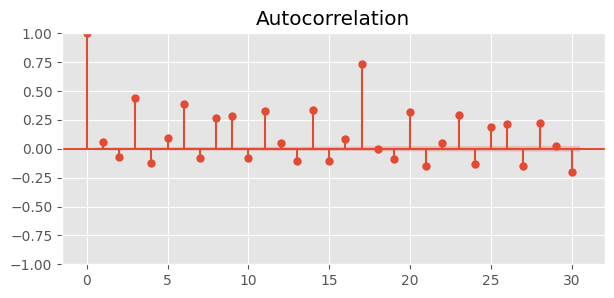

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(ventas, ax=ax, lags=30)

plt.show()

In [ ]:
# las ventas del dia anterior
datos_dia_anterior = promedio_ventas_fecha.shift(1).stack().rename('ventas_dia_anterior').reset_index()
datos_dia_anterior.head()

,date,cluster_store,ventas_dia_anterior
0,2013-01-03,1,2662.000000
1,2013-01-03,2,4698.000000
2,2013-01-03,3,2064.285714
3,2013-01-03,4,3591.333333
4,2013-01-03,5,10686.000000


In [ ]:
# las ventas promedio del semana anterior
datos_semana_anterior = promedio_ventas_fecha.shift(7).stack().rename('ventas_semana_anterior').reset_index()
datos_semana_anterior.head()

,date,cluster_store,ventas_semana_anterior
0,2013-01-09,1,2662.000000
1,2013-01-09,2,4698.000000
2,2013-01-09,3,2064.285714
3,2013-01-09,4,3591.333333
4,2013-01-09,5,10686.000000


In [ ]:
# las ventas promedio dos semanas anterior
datos_quince_anterior = promedio_ventas_fecha.shift(15).stack().rename('ventas_quince_anterior').reset_index()
datos_quince_anterior.head()

,date,cluster_store,ventas_quince_anterior
0,2013-01-17,1,2662.000000
1,2013-01-17,2,4698.000000
2,2013-01-17,3,2064.285714
3,2013-01-17,4,3591.333333
4,2013-01-17,5,10686.000000


In [ ]:
#bd serie (sarimax)
BD_caracteristicas = agregado[caracteristicas]
BD_caracteristicas.head()


,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,state_store__Esmeraldas,state_store__Guayas,...,cluster_store__8,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17
0,0.0,93.14,1676.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,93.14,1691.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,93.14,968.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,93.14,1601.666667,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,93.14,4821.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
BD_caracteristicas_ST = agregado
BD_caracteristicas_ST.head()

,date,cluster_store,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,...,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17,sales
0,2013-01-02,1,0.0,93.14,1676.333333,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2662.000000
1,2013-01-02,2,0.0,93.14,1691.000000,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4698.000000
2,2013-01-02,3,0.0,93.14,968.000000,0.0,0.0,0.0,0.0,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2064.285714
3,2013-01-02,4,0.0,93.14,1601.666667,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3591.333333
4,2013-01-02,5,0.0,93.14,4821.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10686.000000


In [ ]:
# bd regresión
agregado_2 = pd.merge(agregado, datos_dia_anterior, on = ['date','cluster_store'], how='inner')
agregado_2 = pd.merge(agregado_2, datos_semana_anterior, on = ['date','cluster_store'], how='inner')
agregado_2 = pd.merge(agregado_2, datos_quince_anterior, on = ['date','cluster_store'], how='inner')

BD_caracteristicas_2 = agregado_2[caracteristicas+['ventas_dia_anterior']+['ventas_semana_anterior']+['ventas_quince_anterior']]
BD_caracteristicas_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27901 entries, 0 to 27900
Data columns (total 39 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   onpromotion                                  27901 non-null  float64
 1   oil_price                                    27901 non-null  float64
 2   transactions                                 27901 non-null  float64
 3   state_store__Azuay                           27901 non-null  float64
 4   state_store__Bolivar                         27901 non-null  float64
 5   state_store__Chimborazo                      27901 non-null  float64
 6   state_store__Cotopaxi                        27901 non-null  float64
 7   state_store__El Oro                          27901 non-null  float64
 8   state_store__Esmeraldas                      27901 non-null  float64
 9   state_store__Guayas                          27901 non-null  float64
 10

In [ ]:
BD_caracteristicas_2.head()

,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,state_store__Esmeraldas,state_store__Guayas,...,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17,ventas_dia_anterior,ventas_semana_anterior,ventas_quince_anterior
0,0.0,95.49,1411.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2271.333333,1646.666667,2662.000000
1,0.0,95.49,1258.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3544.000000,2471.000000,4698.000000
2,0.0,95.49,810.571429,0.0,0.0,0.0,0.0,0.142857,0.0,0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1399.000000,1176.857143,2064.285714
3,0.0,95.49,1176.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2182.000000,1882.000000,3591.333333
4,0.0,95.49,3412.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7737.000000,5101.000000,10686.000000


In [ ]:
# variable de rta
ventas_2 = agregado_2['sales']
ventas_2

0        2015.000
1        2280.000
2        1370.000
3        1922.000
4        4998.000
           ...   
27896    3124.000
27897    7094.250
27898    2801.200
27899    3024.594
27900    4756.000
Name: sales, Length: 27901, dtype: float64

## PCA

In [ ]:
MM = MinMaxScaler()

#normalizamos los datos
X_Norm = MM.fit_transform(BD_caracteristicas_2)
Nombres = BD_caracteristicas_2.columns
X_Norm = pd.DataFrame(X_Norm, columns = Nombres)

In [ ]:
Num_Componentes = X_Norm.shape[1]

pca = PCA(iterated_power='auto', n_components = Num_Componentes, random_state = 17, svd_solver='auto', tol = 1e-3, whiten = False)

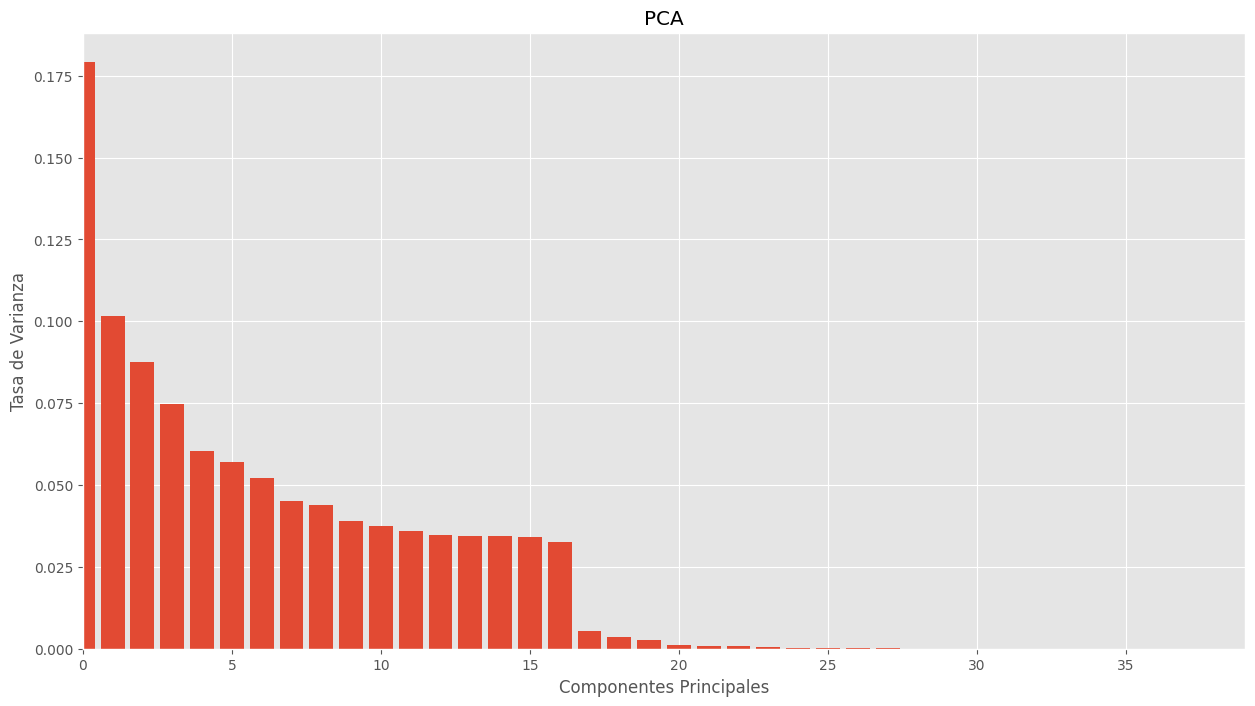

In [ ]:
Variables_principales = pca.fit_transform(X_Norm)

Varianza = pca.explained_variance_ratio_

fig = plt.figure(figsize=(15,8))
plt.bar(np.arange(len(Varianza)), Varianza)
plt.xlabel('Componentes Principales')
plt.ylabel('Tasa de Varianza')
plt.title('PCA')
plt.xlim(0, len(Varianza))
plt.show()

In [ ]:
Importancia_Componentes = pd.DataFrame(Varianza)
Importancia_Componentes = Importancia_Componentes.T

for i in range(X_Norm.shape[1]):
  print(f"Porcentaje de Varianza detectada para las primeras {i} componentes: ", format(100*Importancia_Componentes.loc[:,0:i].sum(axis = 1).values))

Porcentaje de Varianza detectada para las primeras 0 componentes:  [17.91939829]
Porcentaje de Varianza detectada para las primeras 1 componentes:  [28.09687281]
Porcentaje de Varianza detectada para las primeras 2 componentes:  [36.8541279]
Porcentaje de Varianza detectada para las primeras 3 componentes:  [44.34171578]
Porcentaje de Varianza detectada para las primeras 4 componentes:  [50.37116834]
Porcentaje de Varianza detectada para las primeras 5 componentes:  [56.07401567]
Porcentaje de Varianza detectada para las primeras 6 componentes:  [61.28375377]
Porcentaje de Varianza detectada para las primeras 7 componentes:  [65.80597578]
Porcentaje de Varianza detectada para las primeras 8 componentes:  [70.2029088]
Porcentaje de Varianza detectada para las primeras 9 componentes:  [74.09696813]
Porcentaje de Varianza detectada para las primeras 10 componentes:  [77.830439]
Porcentaje de Varianza detectada para las primeras 11 componentes:  [81.4242033]
Porcentaje de Varianza detectad

In [ ]:
Componentes_Seleccionadas = 16

#tasa de varianza explicada
Tasa_Varianza_Explicada = np.sum(Varianza[0:Componentes_Seleccionadas])

Nuevas_Componentes = PCA(Tasa_Varianza_Explicada, random_state = 17, svd_solver='auto', tol = 1e-3, whiten = False)

#transformacion de los datos
X_Norm_PCA = Nuevas_Componentes.fit_transform(X_Norm)

# Tamaño de los datos originales
print('Tamaño de los datos originales con MinMax: ', X_Norm.shape)

# Tamaño de los datos reducidos
print('Tamaño de los datos reducidos: ', X_Norm_PCA.shape)

# %de variaza explicada
print("Porcentaje de la varianza explicada con las componentes seleccionadas: {:.2f}%".format(Tasa_Varianza_Explicada*100))

Tamaño de los datos originales con MinMax:  (27901, 39)
Tamaño de los datos reducidos:  (27901, 17)
Porcentaje de la varianza explicada con las componentes seleccionadas: 95.17%


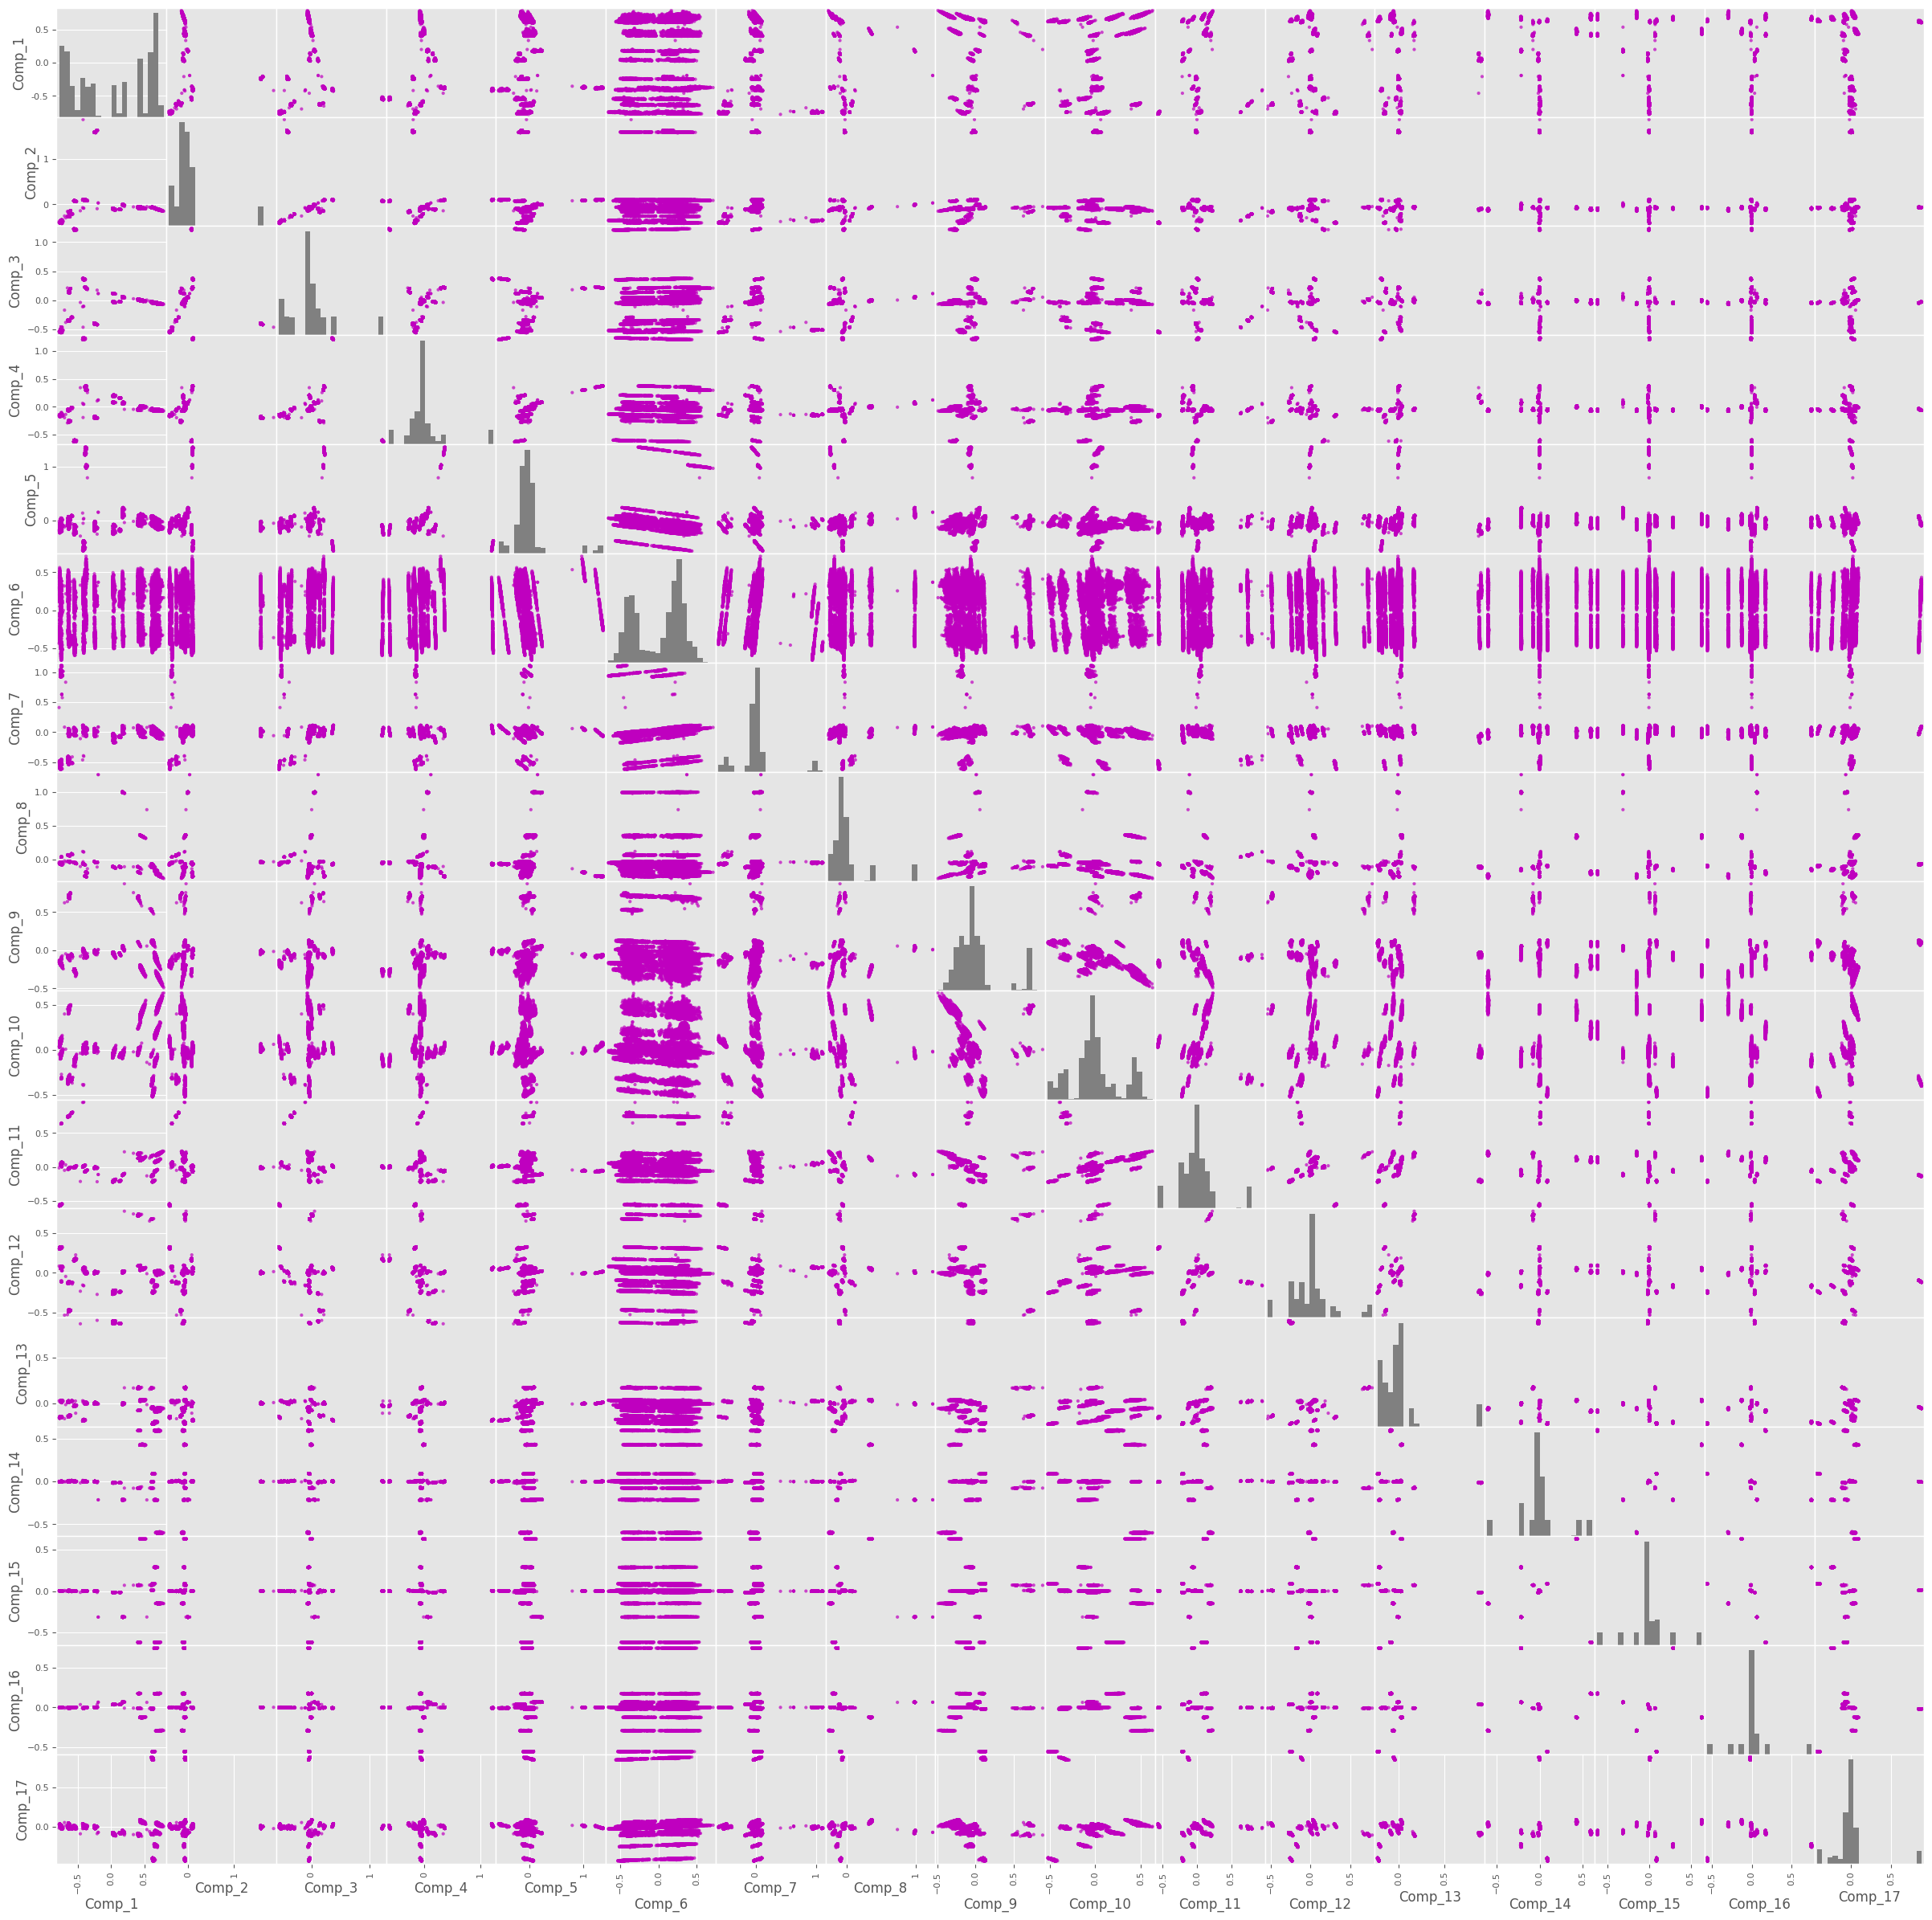

In [ ]:
nombres = [f'Comp_{i+1}' for i in range(17)]

X_Norm_PCA = pd.DataFrame(X_Norm_PCA, columns = nombres)

# Grafica de dispersión e histogramas
pd.plotting.scatter_matrix(X_Norm_PCA, alpha=0.7, figsize=(30,30),
                           color = 'm', hist_kwds = {'bins':20, 'color':'gray'})

plt.show()

## Train test split con PCA

In [ ]:
#se procede hacer la division de los datos, estos datos no tienen datos atipicos ni datos influyentes y la variable X esta normalizada
X_Norm_Train_2, X_Norm_Test_2, Y_Train_2, Y_Test_2 = train_test_split(X_Norm_PCA, ventas_2,
                                                              test_size = 0.25,
                                                              train_size = 0.75,
                                                              random_state = 17)

print("Tamaño de los Datos de Entrenamiento = ", X_Norm_Train_2.shape)
print("Tamaño de los Datos de Validación = ", X_Norm_Test_2.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", Y_Train_2.shape)
print("Tamaño del Vector de Clases de Prueba = ", Y_Test_2.shape)

Tamaño de los Datos de Entrenamiento =  (20925, 17)
Tamaño de los Datos de Validación =  (6976, 17)
Tamaño del Vector de Clases de Entrenamiento =  (20925,)
Tamaño del Vector de Clases de Prueba =  (6976,)


## Train test split sin PCA

In [ ]:
#se procede hacer la division de los datos, estos datos no tienen datos atipicos ni datos influyentes y la variable X esta normalizada
X_Train, X_Test, Y_Train, Y_Test = train_test_split(BD_caracteristicas_2, ventas_2,
                                                              test_size = 0.25,
                                                              train_size = 0.75,
                                                              random_state = 17)

print("Tamaño de los Datos de Entrenamiento = ", X_Train.shape)
print("Tamaño de los Datos de Validación = ", X_Test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", Y_Train.shape)
print("Tamaño del Vector de Clases de Prueba = ", Y_Test.shape)

Tamaño de los Datos de Entrenamiento =  (20925, 39)
Tamaño de los Datos de Validación =  (6976, 39)
Tamaño del Vector de Clases de Entrenamiento =  (20925,)
Tamaño del Vector de Clases de Prueba =  (6976,)


## Regresión sin PCA

Tomando los valores cuyo valor-p es mayor a 0.05

Donde las caracteristicas BD_caracteristicas y la variables respuesta es ventas

In [ ]:
#Creación de modelo
import statsmodels.api as sm

In [ ]:
# Crear y ajustar el modelo de regresión lineal
Modelo_LR_sin_PCA = sm.OLS(Y_Train, sm.add_constant(X_Train))
results_LR_sin_PCA = Modelo_LR_sin_PCA.fit()

In [ ]:
# Resumen de la regresión para obtener valores-p
print(results_LR_sin_PCA.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     4506.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:13:35   Log-Likelihood:            -1.7257e+05
No. Observations:               20925   AIC:                         3.452e+05
Df Residuals:                   20889   BIC:                         3.455e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
# Obtener las componentes con valores-p > 0.05
p_values = results_LR_sin_PCA.pvalues[1:]  # Excluimos la constante
high_p_values = p_values[p_values > 0.05]

In [ ]:
# Crear un nuevo conjunto de datos sin las componentes con valores-p > 0.05
selected_features = X_Train.drop(high_p_values.index, axis=1)

In [ ]:
# Nuevo modelo de regresión lineal con las características seleccionadas
Modelo_LR_valorP = LinearRegression()
Modelo_LR_valorP.fit(selected_features, Y_Train)

LinearRegression()

In [ ]:
# Realizar predicciones en el conjunto de prueba con el nuevo modelo
X_Test_new = X_Test[selected_features.columns]  # Seleccionar las mismas características en el conjunto de prueba
y_pred_test_new = Modelo_LR_valorP.predict(X_Test_new)

In [ ]:
# Calcular métricas para el nuevo modelo
mae_new = mean_absolute_error(Y_Test, y_pred_test_new)
mse_new = mean_squared_error(Y_Test, y_pred_test_new)
rmsle_new = np.sqrt(mean_squared_log_error(Y_Test, y_pred_test_new))

# Mostrar las métricas para el nuevo modelo
print(f'Nuevo Modelo:')
print(f'MAE: {mae_new:.2f}')
print(f'MSE: {mse_new:.2f}')
print(f'RMSLE: {rmsle_new:.2f}')
print(f'R2-score:{r2_score(Y_Test, y_pred_test_new)}')

Nuevo Modelo:
MAE: 608.21
MSE: 1243662.18
RMSLE: 0.18
R2-score:0.8287578406704474


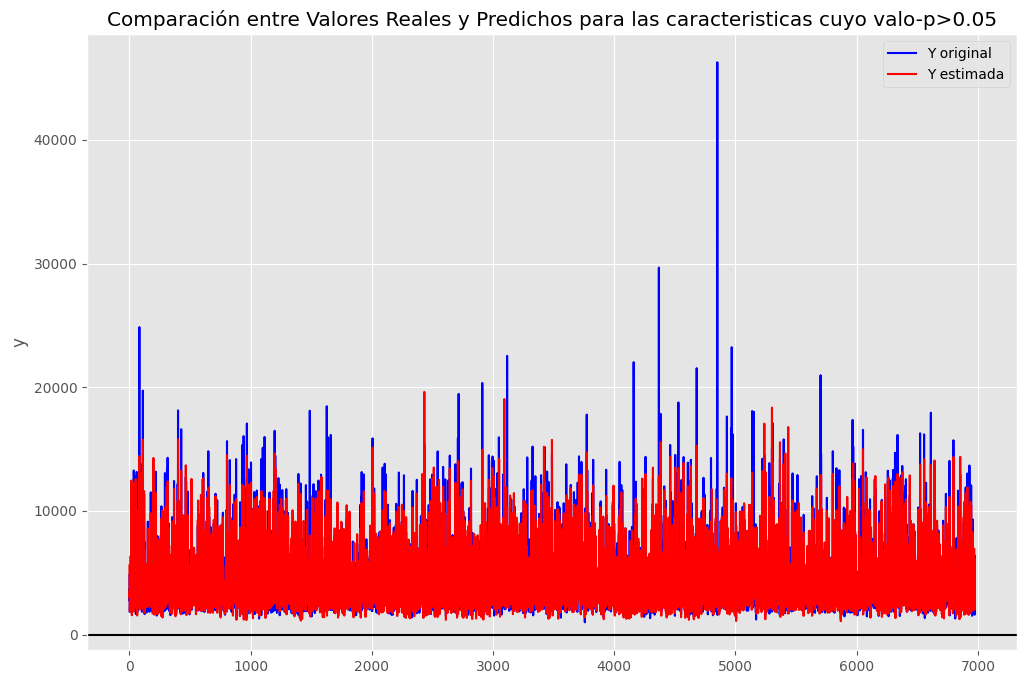

In [ ]:
# Estima los valores de salida del modelo de regresión, se ponen los datos de prueba
fig = plt.figure(figsize=(12,8))

line_1 = plt.plot(np.arange(len(Y_Test)), Y_Test, color = 'b', label='Y original')
line_2 = plt.plot(np.arange(len(Y_Test)), y_pred_test_new, color = 'r', label='Y estimada')

# Elegir color de la linea horizontal de referencia
plt.axhline(0, color="black")
plt.legend()

# Titulo de la gráfica
plt.title('Comparación entre Valores Reales y Predichos para las caracteristicas cuyo valo-p>0.05')

# Etiqueta del eje x
plt.xlabel('')

# Etiqueta del eje y
plt.ylabel('y')

# Mostrar gráfica
plt.show()

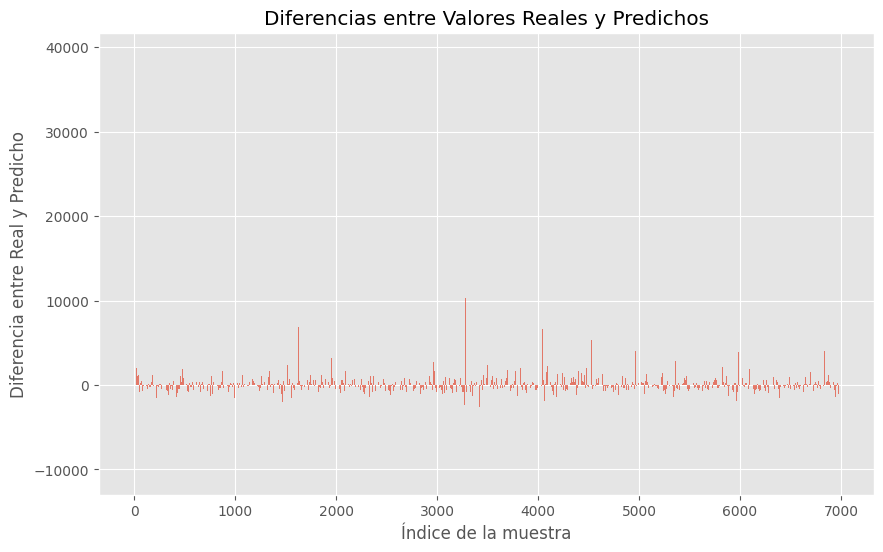

In [ ]:
# Calcula las diferencias entre los valores reales y predichos
diferencias_valorP = Y_Test - y_pred_test_new

# Gráfico de barras para visualizar las diferencias
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(diferencias_valorP)), diferencias_valorP, alpha=0.7)
plt.xlabel('Índice de la muestra')
plt.ylabel('Diferencia entre Real y Predicho')
plt.title('Diferencias entre Valores Reales y Predichos')
plt.show()

**NOTA: como interpretar**

Lo anterior muestra un gráfico de barras que muestra las diferencias entre los valores reales y las predicciones para cada muestra en el conjunto de prueba. Las barras que están por encima de cero indican casos donde la predicción fue menor que el valor real, y las barras por debajo de cero indican lo contrario. Esto proporciona una representación visual de la discrepancia entre las predicciones y los valores reales para cada muestra individualmente.

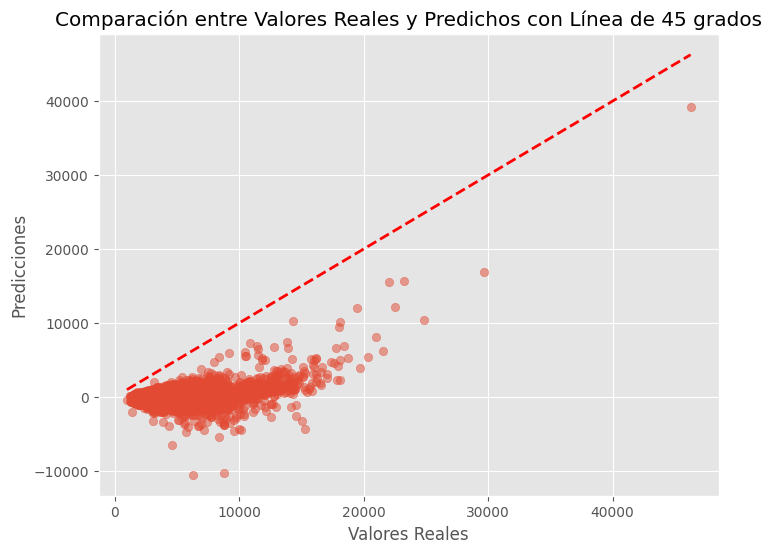

In [ ]:
# Gráfico de dispersión con línea de 45 grados
plt.figure(figsize=(8, 6))
plt.scatter(Y_Test, diferencias_valorP, alpha=0.5)
plt.plot([min(Y_Test), max(Y_Test)], [min(Y_Test), max(Y_Test)], 'r--', lw=2)  # Línea de 45 grados
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predichos con Línea de 45 grados')
plt.show()

**NOTA: Como interpretar**

Este gráfico de dispersión muestra los valores reales en el eje x y las predicciones en el eje y. La línea roja discontinua representa la línea de 45 grados, donde los puntos deberían estar si las predicciones coincidieran exactamente con los valores reales. Puntos por encima de esta línea indican sobreestimación, mientras que puntos por debajo indican subestimación.

## Modelo regresión base con PCA

In [ ]:
model_LR = LinearRegression()

#se crea un model de regresión lineal
model_LR.fit(X_Norm_Train_2, Y_Train_2)

LinearRegression()

In [ ]:
# Realizar predicciones en el conjunto de prueba
Y_pred_LR = model_LR.predict(X_Norm_Test_2)

In [ ]:
# Validación por puntaje o score
Puntaje_1 = model_LR.score(X_Norm_Test_2, Y_Test_2)

Validacion = cross_val_score(model_LR, X_Norm_Test_2,
                             Y_Test_2, cv = 5,
                             scoring = 'neg_mean_squared_error')

# Se calcula la media y desviación estándar de la validación cruzada
Puntaje_2 = np.array([Validacion.mean(), Validacion.std()])

# Se calcula el error promedio absoluto
Puntaje_5 = mean_absolute_error(Y_Test_2, Y_pred_LR)

mae = mean_absolute_error(Y_Test_2, Y_pred_LR)
mse = mean_squared_error(Y_Test_2, Y_pred_LR)
rmsle = np.sqrt(mean_squared_log_error(Y_Test_2, Y_pred_LR))

print("Puntaje = {:.4f}".format(Puntaje_1))
print("Media = {:.4f}".format(Puntaje_2[0]))
print("Desviación Estándar = {:.15f}".format(Puntaje_2[1]))
print("MAE = {:.4f}".format(Puntaje_5))
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSLE: {rmsle:.2f}')
print(f'R2-score:{r2_score(Y_Test_2, Y_pred_LR)}')

Puntaje = 0.7014
Media = -2181648.1125
Desviación Estándar = 550953.662456704885699
MAE = 910.3409
MAE: 910.34
MSE: 2168746.29
RMSLE: 0.25
R2-score:0.7013812887119262


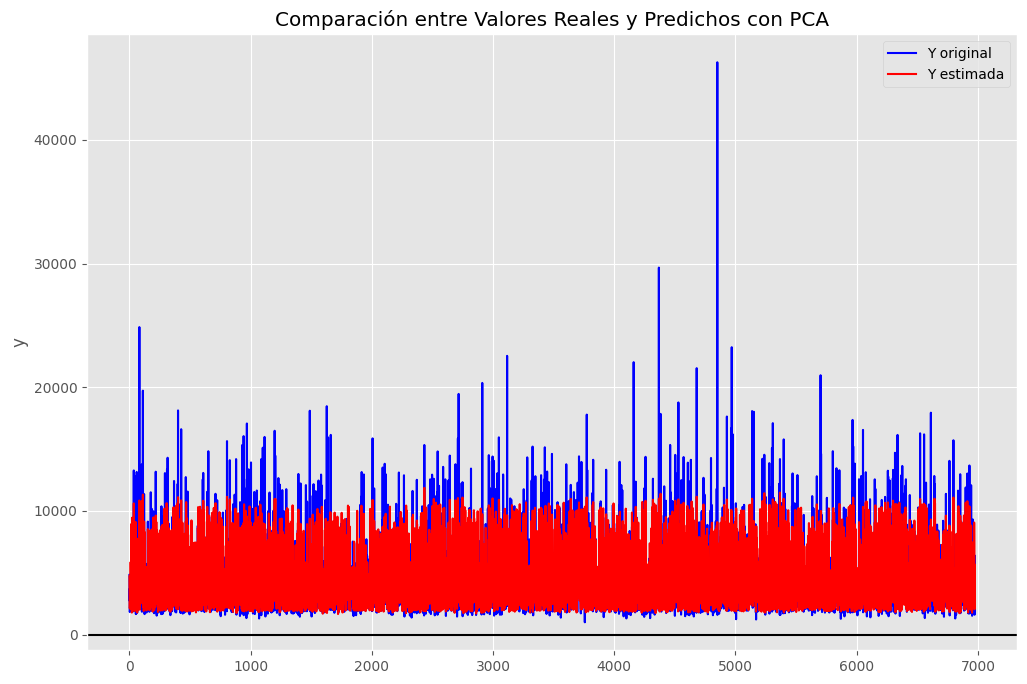

In [ ]:
# Estima los valores de salida del modelo de regresión, se ponen los datos de prueba
fig = plt.figure(figsize=(12,8))

line_1 = plt.plot(np.arange(len(Y_Test_2)), Y_Test_2, color = 'b', label='Y original')
line_2 = plt.plot(np.arange(len(Y_Test_2)), Y_pred_LR, color = 'r', label='Y estimada')

# Elegir color de la linea horizontal de referencia
plt.axhline(0, color="black")
plt.legend()

# Titulo de la gráfica
plt.title('Comparación entre Valores Reales y Predichos con PCA')

# Etiqueta del eje x
plt.xlabel('')

# Etiqueta del eje y
plt.ylabel('y')

# Mostrar gráfica
plt.show()

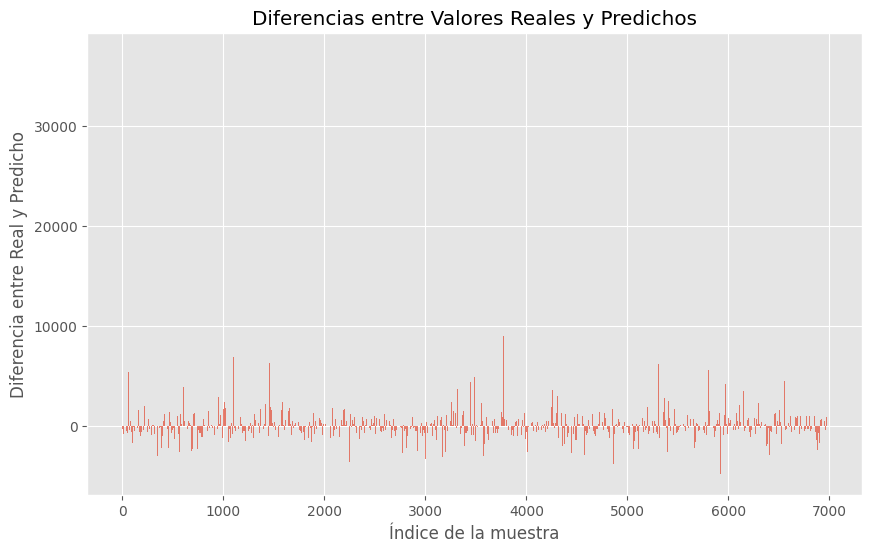

In [ ]:
# Calcula las diferencias entre los valores reales y predichos
diferencias_LR = Y_Test_2 - Y_pred_LR

# Gráfico de barras para visualizar las diferencias
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(diferencias_LR)), diferencias_LR, alpha=0.7)
plt.xlabel('Índice de la muestra')
plt.ylabel('Diferencia entre Real y Predicho')
plt.title('Diferencias entre Valores Reales y Predichos')
plt.show()

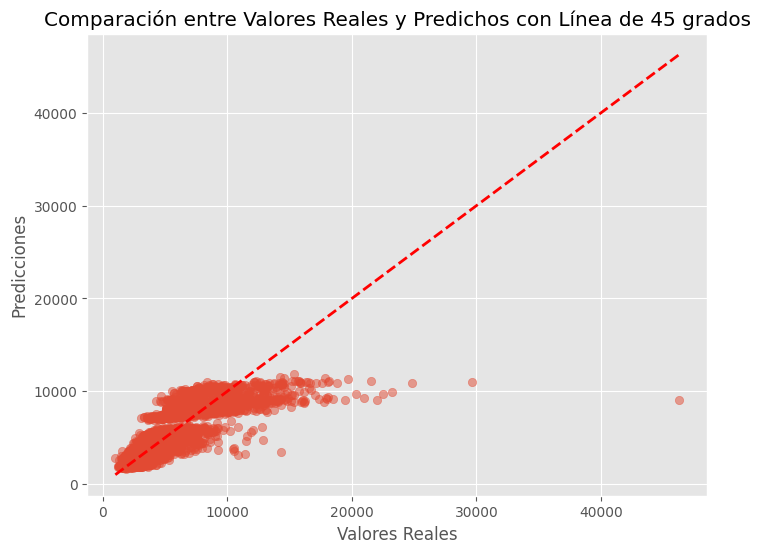

In [ ]:
# Gráfico de dispersión con línea de 45 grados
plt.figure(figsize=(8, 6))
plt.scatter(Y_Test_2, Y_pred_LR, alpha=0.5)
plt.plot([min(Y_Test_2), max(Y_Test_2)], [min(Y_Test_2), max(Y_Test_2)], 'r--', lw=2)  # Línea de 45 grados
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predichos con Línea de 45 grados')
plt.show()

## modelo xgboost sin PCA

In [ ]:
# MODELO
model_xgb_sin_pca = XGBRegressor(max_depth = 3)

In [ ]:
# cross-validation
y_pred_xgb_sin_pca_cv = cross_val_predict(model_xgb_sin_pca, X_Train, Y_Train, cv=5)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
resultados_xgb_sin_pca = model_xgb_sin_pca.fit(X_Test, Y_Test)

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_xgb_sin_pca = resultados_xgb_sin_pca.predict(X_Test)

In [ ]:
# Comparar las predicciones con los valores reales y calcular métricas
mae = mean_absolute_error(Y_Test, y_pred_xgb_sin_pca)
mse = mean_squared_error(Y_Test, y_pred_xgb_sin_pca)
rmsle = np.sqrt(mean_squared_log_error(Y_Test, y_pred_xgb_sin_pca))

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSLE: {rmsle:.2f}')
print(f'R2-score:{r2_score(Y_Test, y_pred_xgb_sin_pca)}')

MAE: 399.05
MSE: 546515.36
RMSLE: 0.12
R2-score:0.924749283596711


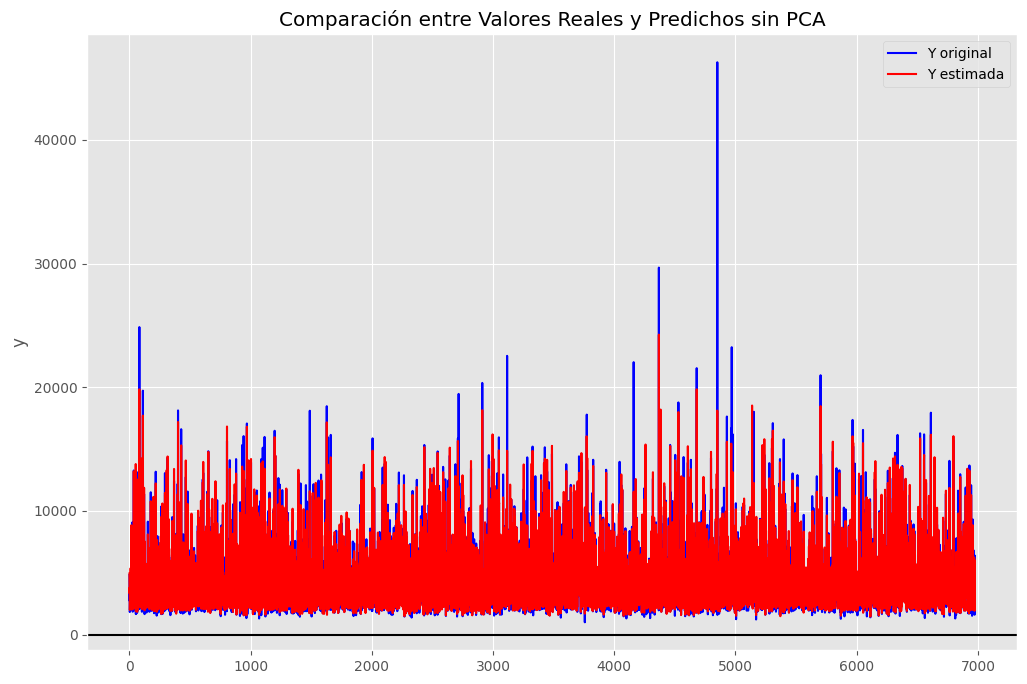

In [ ]:
# Estima los valores de salida del modelo de regresión, se ponen los datos de prueba
fig = plt.figure(figsize=(12,8))

line_1 = plt.plot(np.arange(len(Y_Test)), Y_Test, color = 'b', label='Y original')
line_2 = plt.plot(np.arange(len(Y_Test)), y_pred_xgb_sin_pca, color = 'r', label='Y estimada')

# Elegir color de la linea horizontal de referencia
plt.axhline(0, color="black")
plt.legend()

# Titulo de la gráfica
plt.title('Comparación entre Valores Reales y Predichos sin PCA')

# Etiqueta del eje x
plt.xlabel('')

# Etiqueta del eje y
plt.ylabel('y')

# Mostrar gráfica
plt.show()

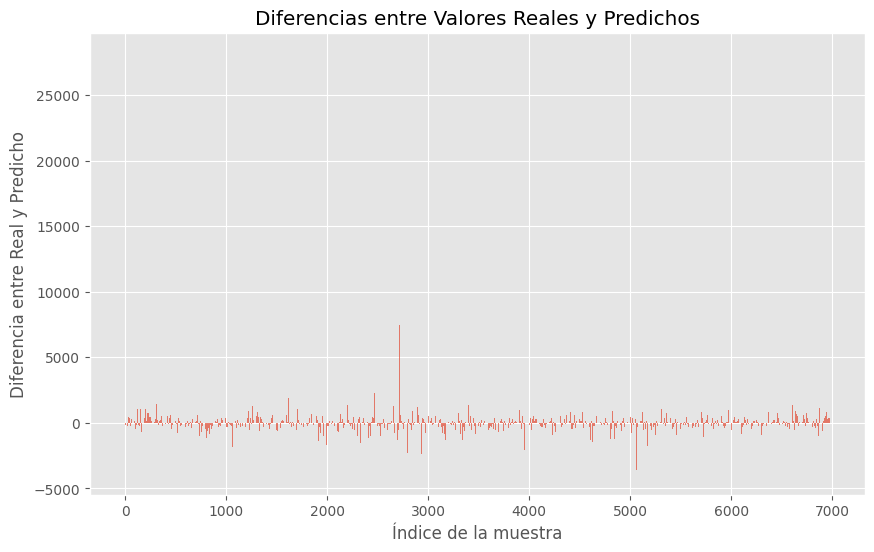

In [ ]:
# Calcula las diferencias entre los valores reales y predichos
diferencias_xgb_sin_pca = Y_Test - y_pred_xgb_sin_pca

# Gráfico de barras para visualizar las diferencias
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(diferencias_xgb_sin_pca)), diferencias_xgb_sin_pca, alpha=0.7)
plt.xlabel('Índice de la muestra')
plt.ylabel('Diferencia entre Real y Predicho')
plt.title('Diferencias entre Valores Reales y Predichos')
plt.show()

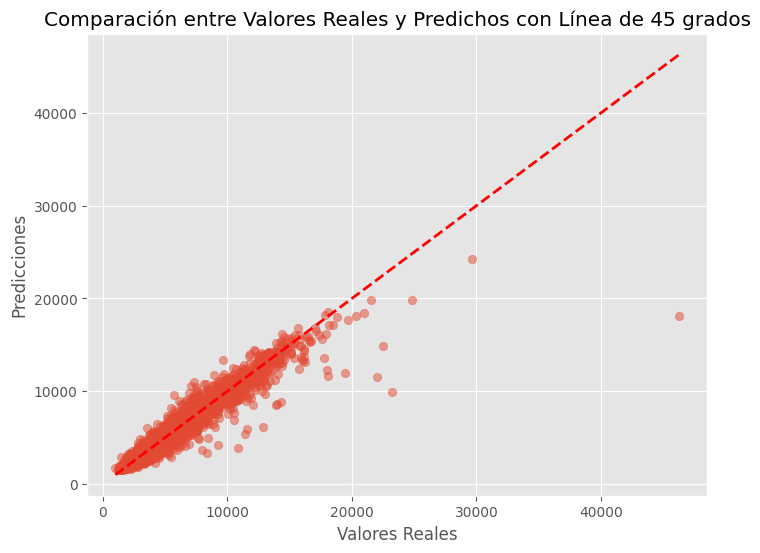

In [ ]:
# Gráfico de dispersión con línea de 45 grados
plt.figure(figsize=(8, 6))
plt.scatter(Y_Test, y_pred_xgb_sin_pca, alpha=0.5)
plt.plot([min(Y_Test), max(Y_Test)], [min(Y_Test), max(Y_Test)], 'r--', lw=2)  # Línea de 45 grados
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predichos con Línea de 45 grados')
plt.show()

## modelo xgboost con PCA

In [ ]:
! pip install xgboost

In [ ]:
dtrain = xgb.DMatrix(X_Norm_Train_2, label = Y_Train_2)
dtest = xgb.DMatrix(X_Norm_Test_2)

In [ ]:
# MODELO
model_xgb = XGBRegressor(max_depth = 3)

In [ ]:
# cross-validation
y_pred_xg_cv = cross_val_predict(model_xgb, X_Norm_Train_2, Y_Train_2, cv=5)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
resultados_xgb = model_xgb.fit(X_Norm_Test_2, Y_Test_2)

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred_xgb = resultados_xgb.predict(X_Norm_Test_2)

In [ ]:
# Comparar las predicciones con los valores reales y calcular métricas
mae = mean_absolute_error(Y_Test_2, y_pred_xgb)
mse = mean_squared_error(Y_Test_2, y_pred_xgb)
rmsle = np.sqrt(mean_squared_log_error(Y_Test_2, y_pred_xgb))

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSLE: {rmsle:.2f}')
print(f'R2-score:{r2_score(Y_Test_2,y_pred_xgb)}')

MAE: 469.48
MSE: 676267.48
RMSLE: 0.15
R2-score:0.9068834721637359


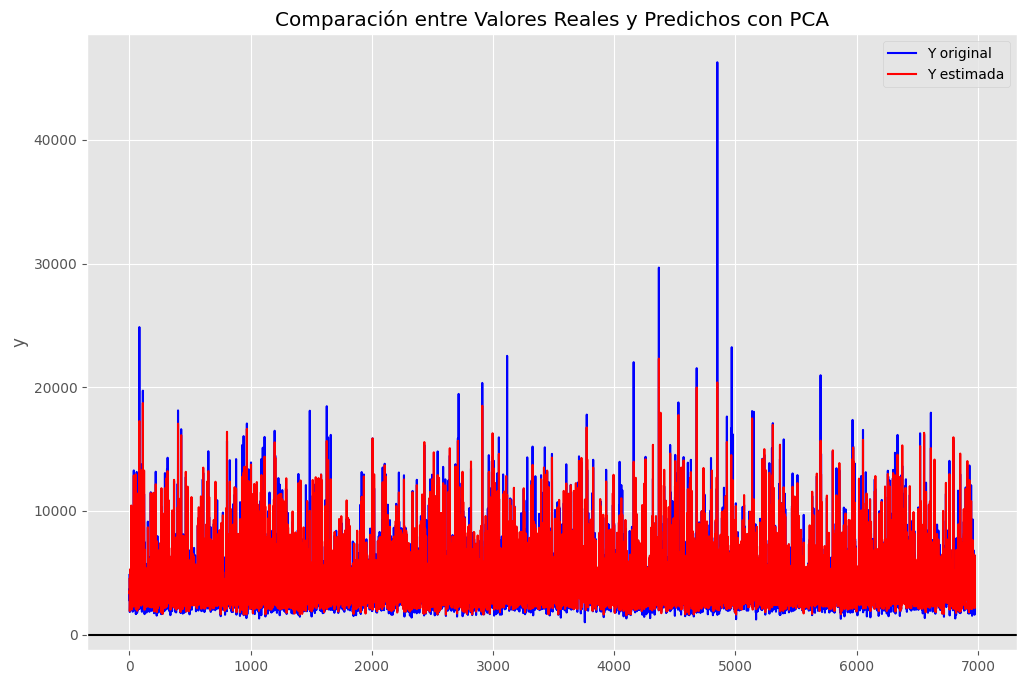

In [ ]:
# Estima los valores de salida del modelo de regresión, se ponen los datos de prueba
fig = plt.figure(figsize=(12,8))

line_1 = plt.plot(np.arange(len(Y_Test_2)), Y_Test_2, color = 'b', label='Y original')
line_2 = plt.plot(np.arange(len(Y_Test_2)), y_pred_xgb, color = 'r', label='Y estimada')

# Elegir color de la linea horizontal de referencia
plt.axhline(0, color="black")
plt.legend()

# Titulo de la gráfica
plt.title('Comparación entre Valores Reales y Predichos con PCA')

# Etiqueta del eje x
plt.xlabel('')

# Etiqueta del eje y
plt.ylabel('y')

# Mostrar gráfica
plt.show()

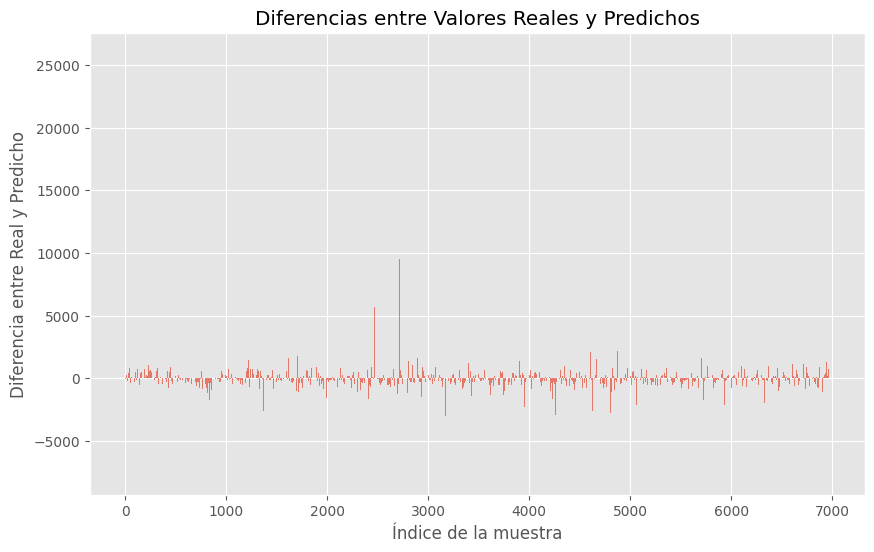

In [ ]:
# Calcula las diferencias entre los valores reales y predichos
diferencias = Y_Test_2 - y_pred_xgb

# Gráfico de barras para visualizar las diferencias
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(diferencias)), diferencias, alpha=0.7)
plt.xlabel('Índice de la muestra')
plt.ylabel('Diferencia entre Real y Predicho')
plt.title('Diferencias entre Valores Reales y Predichos')
plt.show()

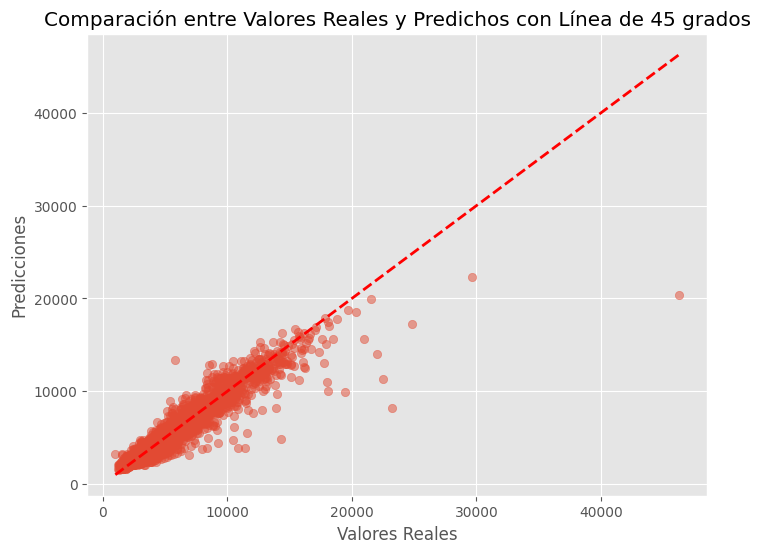

In [ ]:
# Gráfico de dispersión con línea de 45 grados
plt.figure(figsize=(8, 6))
plt.scatter(Y_Test_2, y_pred_xgb, alpha=0.5)
plt.plot([min(Y_Test_2), max(Y_Test_2)], [min(Y_Test_2), max(Y_Test_2)], 'r--', lw=2)  # Línea de 45 grados
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predichos con Línea de 45 grados')
plt.show()


## Serie de tiempo

In [ ]:
BD_caracteristicas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28367 entries, 0 to 28366
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   onpromotion                                  28367 non-null  float64
 1   oil_price                                    28367 non-null  float64
 2   transactions                                 28367 non-null  float64
 3   state_store__Azuay                           28367 non-null  float64
 4   state_store__Bolivar                         28367 non-null  float64
 5   state_store__Chimborazo                      28367 non-null  float64
 6   state_store__Cotopaxi                        28367 non-null  float64
 7   state_store__El Oro                          28367 non-null  float64
 8   state_store__Esmeraldas                      28367 non-null  float64
 9   state_store__Guayas                          28367 non-null  float64
 10

In [ ]:
BD_caracteristicas.head()

,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,state_store__Esmeraldas,state_store__Guayas,...,cluster_store__8,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17
0,0.0,93.14,1676.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,93.14,1691.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,93.14,968.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,93.14,1601.666667,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,93.14,4821.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ventas.info()

<class 'pandas.core.series.Series'>
RangeIndex: 28367 entries, 0 to 28366
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
28367 non-null  float64
dtypes: float64(1)
memory usage: 221.7 KB


### Día

La base de datos esta recolectada de forma diaria

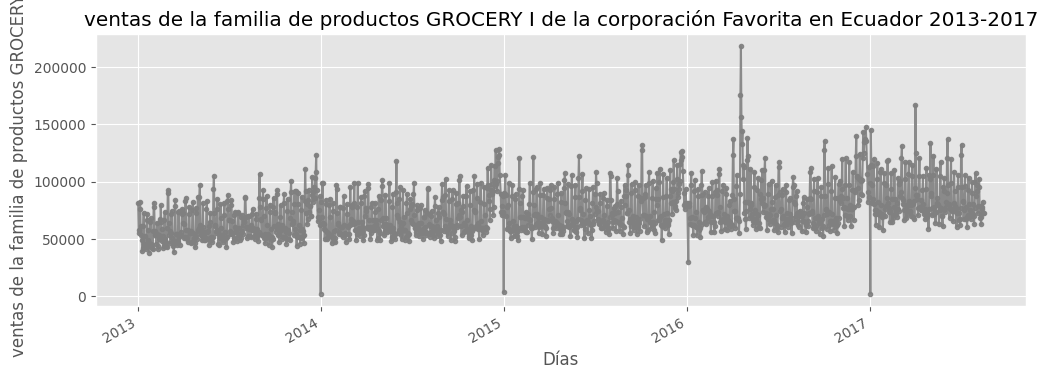

In [ ]:
#Grafica de la serie en bruto
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = BD_caracteristicas_ST.groupby('date')['sales'].sum().\
                plot(y="sales", marker=".", alpha=0.9, color='grey');

average_week_demand.plot(ax=ax)
_= ax.set(
    title="ventas de la familia de productos GROCERY I de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Días",
    ylabel="ventas de la familia de productos GROCERY I",
)

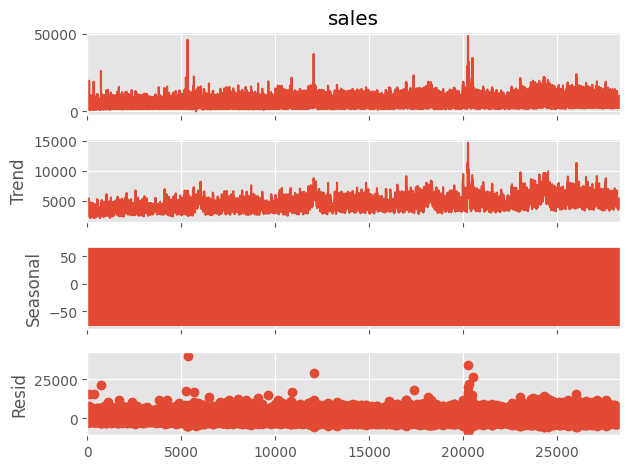

In [ ]:
#descomposición de la serie en bruto tomada por mes
descomposicion_dia = sm.tsa.seasonal_decompose(BD_caracteristicas_ST['sales'],
                                                  model='additive', period = 12)
fig = descomposicion_dia.plot()

### Mes

Se organiza la base de datos para que por meses, se hace esto para ver la serie con mas detalle

In [ ]:
# Agrupar por mes
df_mensual = BD_caracteristicas_ST.groupby(pd.Grouper(key = 'date', freq='M')).sum()

df_mensual.head()

,cluster_store,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,state_store__Esmeraldas,...,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,4590,0.0,48287.82,909561.904762,37.50,6.0,30.0,12.0,14.285714,7.50,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,1.633081e+06
2013-02-28,4284,0.0,45412.10,848865.442857,35.00,5.6,28.0,11.2,13.333333,7.00,...,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,1.558850e+06
2013-03-31,4743,0.0,49125.41,967280.328571,38.75,6.2,31.0,12.4,14.761905,7.75,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,1.851933e+06
2013-04-30,4590,0.0,46814.43,925179.576190,37.50,6.0,30.0,12.0,14.285714,7.50,...,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,1.796459e+06
2013-05-31,4743,0.0,49882.93,963914.957143,38.75,6.2,31.0,12.4,14.761905,6.60,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,1.874527e+06


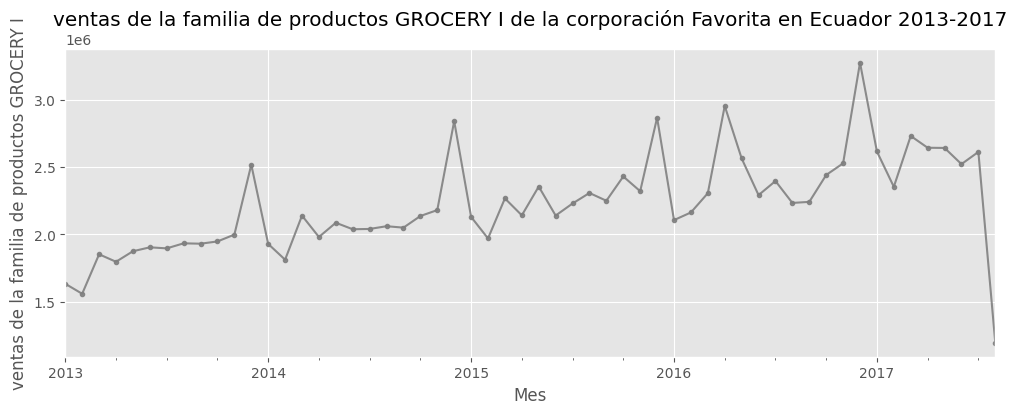

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_mensual.groupby('date')['sales'].sum().\
                plot(y="sales", marker=".", alpha=0.9, color='grey');


average_week_demand.plot(ax=ax)
_ = ax.set(
    title="ventas de la familia de productos GROCERY I de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Mes",
    ylabel="ventas de la familia de productos GROCERY I",
)

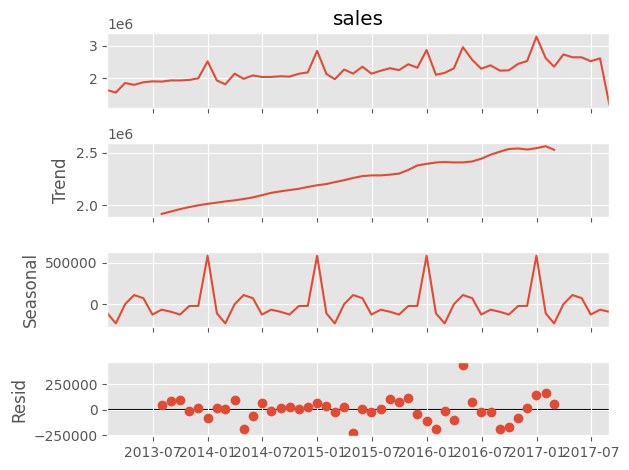

In [ ]:
#descomposición de la serie en bruto tomada por mes
descomposicion_mes = sm.tsa.seasonal_decompose(df_mensual['sales'],
                                                  model='additive', period = 12)
fig = descomposicion_mes.plot()

<Axes: xlabel='date', ylabel='sales'>

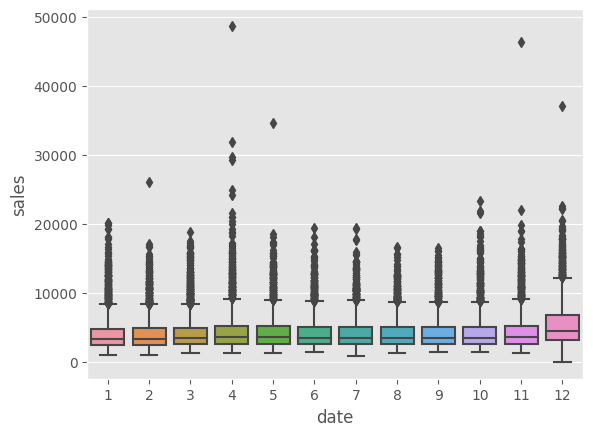

In [ ]:
#box-plot dia semana (0 = lunes y 6 = domingo)
sns.boxplot(data = BD_caracteristicas_ST, x = BD_caracteristicas_ST['date'].dt.month, y = BD_caracteristicas_ST['sales'])

### Semana

In [ ]:
# Agrupar por semana y por cada tienda
df_semana = BD_caracteristicas_ST.groupby([pd.Grouper(key='date', freq='W')]).sum()

df_semana.head()

,cluster_store,onpromotion,oil_price,transactions,state_store__Azuay,state_store__Bolivar,state_store__Chimborazo,state_store__Cotopaxi,state_store__El Oro,state_store__Esmeraldas,...,cluster_store__9,cluster_store__10,cluster_store__11,cluster_store__12,cluster_store__13,cluster_store__14,cluster_store__15,cluster_store__16,cluster_store__17,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,765,0.0,7912.99,171683.809524,6.25,1.0,5.0,2.0,2.380952,1.25,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,352281.726190
2013-01-13,1071,0.0,11119.70,210380.023810,8.75,1.4,7.0,2.8,3.333333,1.75,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,377557.761905
2013-01-20,1071,0.0,11290.21,209796.500000,8.75,1.4,7.0,2.8,3.333333,1.75,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,365023.933333
2013-01-27,1071,0.0,11348.52,206306.573810,8.75,1.4,7.0,2.8,3.333333,1.75,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,366167.921429
2013-02-03,1071,0.0,11586.86,214219.685714,8.75,1.4,7.0,2.8,3.333333,1.75,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,388173.223810


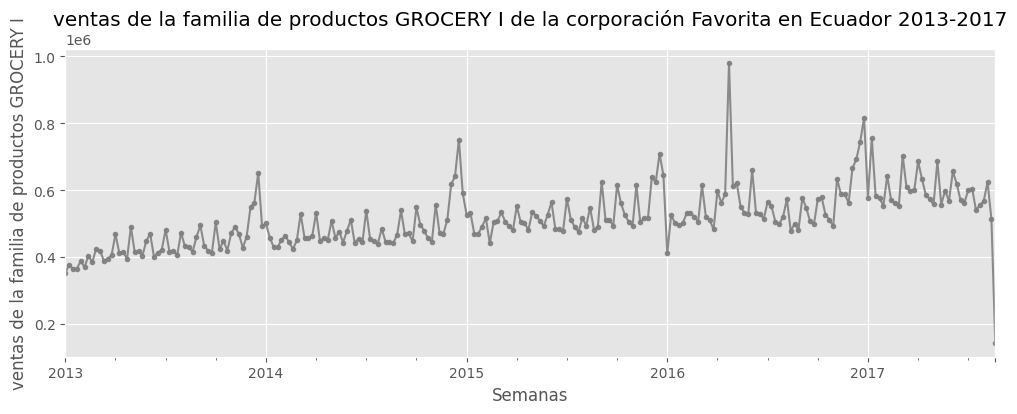

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_semana.groupby('date')['sales'].sum().\
                plot(y="sales", marker=".", alpha=0.9, color='grey');


average_week_demand.plot(ax=ax)
_ = ax.set(
    title="ventas de la familia de productos GROCERY I de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Semanas",
    ylabel="ventas de la familia de productos GROCERY I",
)

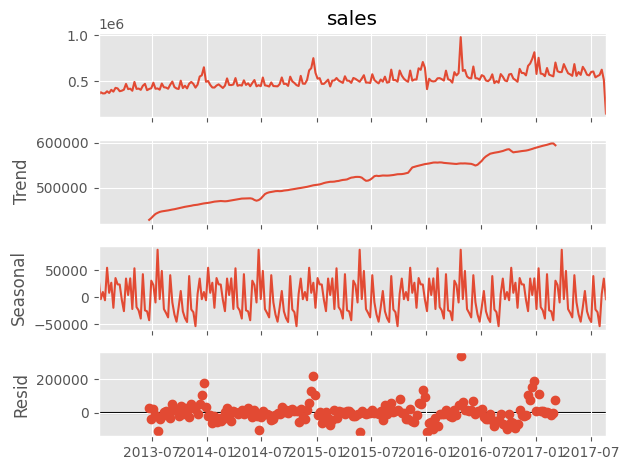

In [ ]:
#descomposición de la serie en bruto tomada por semana
descomposicion_semana = sm.tsa.seasonal_decompose(df_semana['sales'],
                                                  model='additive', period = 12*4)
fig = descomposicion_semana.plot()

<Axes: xlabel='date', ylabel='sales'>

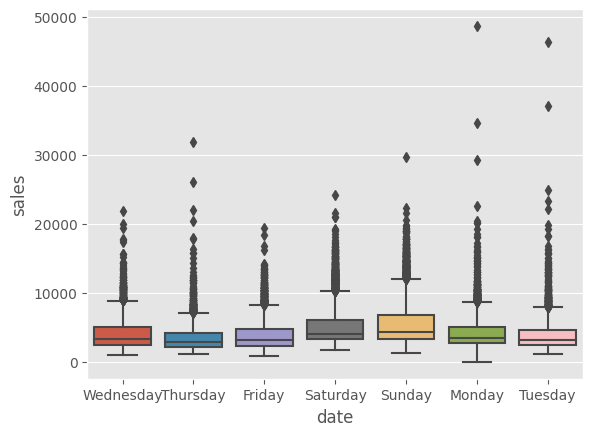

In [ ]:
#box-plot dia semana
sns.boxplot(data = BD_caracteristicas_ST, x = BD_caracteristicas_ST['date'].dt.day_name(), y = BD_caracteristicas_ST['sales'])

In [ ]:
# División datos de testeo y entrenamiento
Train = df_semana[:'2015']
Test = df_semana['2016':]
Train_size = len(Train)
Test_size = len(Test)

### Modelo SARIMAX

Creación de una grilla para escoger cuales son los mejores modelos con base a los parametros, al AIC, BIC, MAE, MSE, HQIC

In [ ]:
# Definir los parámetros para buscar en la grilla

p = range(0, 3)  # Rango para el orden AR(p)
d = range(0, 2)  # Rango para el orden de integración d
q = range(0, 3)  # Rango para el orden MA(q)
P = range(0, 2)  # Rango para el orden AR estacional P
D = range(0, 2)  # Rango para el orden de integración estacional D
Q = range(0, 2)  # Rango para el orden MA estacional Q
s = 52  # Período estacionalidad

In [ ]:
criterios = pd.DataFrame()

# Realizar la búsqueda en la grilla manualmente
for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        try:
                            # Crear el modelo SARIMAX con los parámetros actuales
                            model = SARIMAX(Train['sales'], order=(p_val, d_val, q_val),
                                            seasonal_order=(P_val, D_val, Q_val, s))

                            # Ajustar el modelo a los datos
                            result = model.fit()

                            # Calcular el puntajes
                            score_AIC = result.aic #Criterio de información de Akaike
                            score_BIC = result.bic #Criterio de información de Bayes
                            #score_MAE = result.mae #Error promedio absoluto del pronostico
                            #score_MSE = result.mse #Error cuadratico medio
                            #score_RMSLE = rmsle()
                            score_HQIC = result.hqic #Criterio de información de Hannan-Quinn

                            criterios = criterios.append(pd.Series([(p_val, d_val, q_val,P_val, D_val, Q_val, s),
                                      score_AIC, score_BIC,score_HQIC],
                                      index = ['Paremetros','AIC','BIC','HQIC']) ,
                                      ignore_index = True)

                        except:
                            continue

criterios


,Paremetros,AIC,BIC,HQIC
0,"(0, 0, 0, 0, 0, 0, 52)",4530.409231,4533.459087,4531.647951
1,"(0, 0, 0, 0, 0, 1, 52)",4537.534399,4543.634111,4540.011838
2,"(0, 0, 0, 0, 1, 0, 52)",2565.714199,2568.358590,2566.785520
3,"(0, 0, 0, 0, 1, 1, 52)",2542.110487,2547.399269,2544.253128
4,"(0, 0, 0, 1, 0, 0, 52)",4147.046336,4153.146048,4149.523775
...,...,...,...,...
139,"(2, 1, 2, 0, 1, 1, 52)",2450.426355,2466.234729,2456.829288
140,"(2, 1, 2, 1, 0, 0, 52)",3761.486900,3779.747451,3768.903926
141,"(2, 1, 2, 1, 0, 1, 52)",3763.062164,3784.366140,3771.715360
142,"(2, 1, 2, 1, 1, 0, 52)",2439.273353,2455.081727,2445.676286


In [ ]:
# 10 modelos con el menor AIC
criterios.nsmallest(10,'AIC')

,Paremetros,AIC,BIC,HQIC
114,"(2, 0, 2, 0, 1, 0, 52)",2402.887421,2416.109376,2408.244024
106,"(2, 0, 1, 0, 1, 0, 52)",2403.287597,2413.865160,2407.572878
118,"(2, 0, 2, 1, 1, 0, 52)",2404.846206,2420.712552,2411.274129
115,"(2, 0, 2, 0, 1, 1, 52)",2405.230924,2421.097269,2411.658847
107,"(2, 0, 1, 0, 1, 1, 52)",2405.266001,2418.487955,2410.622603
110,"(2, 0, 1, 1, 1, 0, 52)",2405.266638,2418.488592,2410.623240
66,"(1, 0, 2, 0, 1, 0, 52)",2406.306513,2416.884076,2410.591795
119,"(2, 0, 2, 1, 1, 1, 52)",2406.718058,2425.228794,2414.217301
67,"(1, 0, 2, 0, 1, 1, 52)",2408.093694,2421.315648,2413.450296
63,"(1, 0, 1, 1, 1, 1, 52)",2410.475392,2423.697346,2415.831994


##### Modelo 119: SARIMAX (2,0,2)(1,1,1)[52]

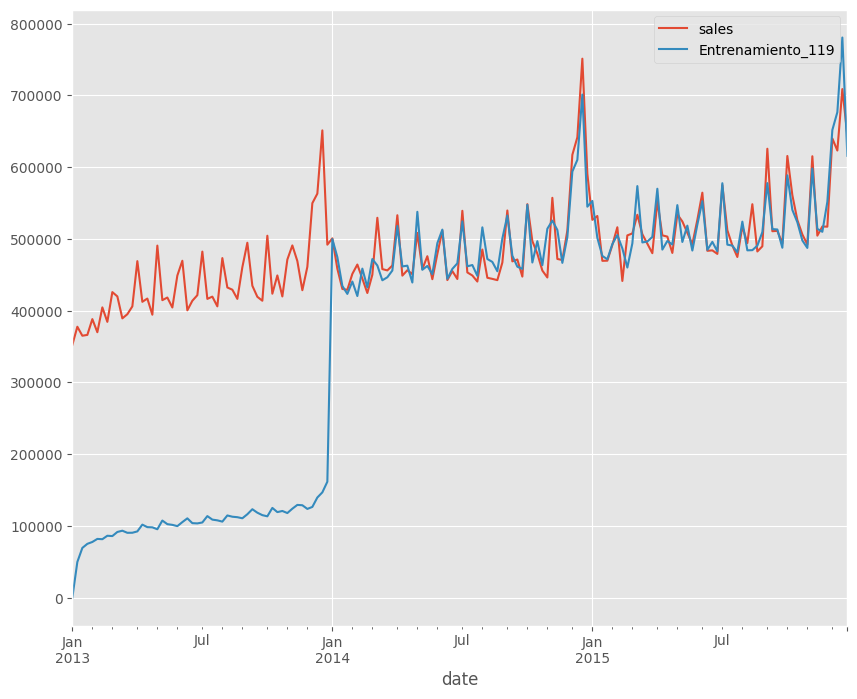

In [ ]:
# Modelo SARIMAX
modelo_119 = sm.tsa.SARIMAX(Train['sales'], order=(2, 0, 2), seasonal_order=(1, 1, 1, 52))
resultados_119 = modelo_119.fit()
Train['Entrenamiento_119'] = resultados_119.fittedvalues
plot = Train[['sales', 'Entrenamiento_119']].plot(figsize=(10, 8))

In [ ]:
# Summary
print(resultados_119.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                  156
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -1196.359
Date:                              Sat, 18 Nov 2023   AIC                           2406.718
Time:                                      00:56:29   BIC                           2425.229
Sample:                                  01-06-2013   HQIC                          2414.217
                                       - 12-27-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5000      0.269      5.581      0.000       0.973       2.027
ar.L2         -0.50

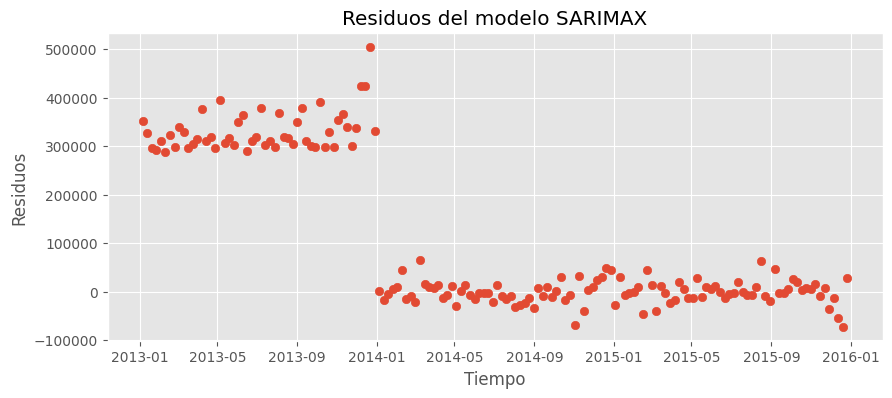

In [ ]:
# Residuales
residuales_119 = resultados_119.resid

# Graficar los residuales
plt.figure(figsize=(10, 4))
plt.scatter(Train.index, residuales_119)
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

In [ ]:
#Resumen de normalidad, p-valor, skewness y curtosis
Normalidad_119 = resultados_119.test_normality('jarquebera')

print("Prueba de normalidad Jarque-Bera:", Normalidad_119[0][0])
print("Prueba de normalidad P-values:", Normalidad_119[0][1])
print("Estadístico de prueba Skewness:", Normalidad_119[0][2])
print("Curtorsis:",Normalidad_119[0][3])

Prueba de normalidad Jarque-Bera: 5.3158693820306855
Prueba de normalidad P-values: 0.07009283572035281
Estadístico de prueba Skewness: -0.004426881082278481
Curtorsis: 4.1075471543263795


In [ ]:
#Pronosticar resultados
forecast_119 = resultados_119.forecast(steps = Test_size+52)
forecast_119

2016-01-03    564051.062039
2016-01-10    571423.526538
2016-01-17    509526.845036
2016-01-24    510090.498854
2016-01-31    532199.771443
                  ...      
2018-07-22    585177.234681
2018-07-29    627995.581505
2018-08-05    604439.417259
2018-08-12    658802.485597
2018-08-19    592458.720930
Freq: W-SUN, Name: predicted_mean, Length: 138, dtype: float64

<Axes: xlabel='date'>

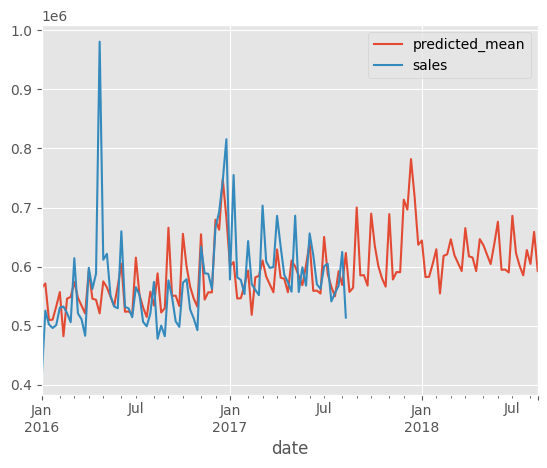

In [ ]:
forecast_119.plot(legend=True)
Test['sales'][:-1].plot(legend=True)

#### Modelo 106: SARIMAX(2,0,1)(0,1,0)[52]


*texto en cursiva*

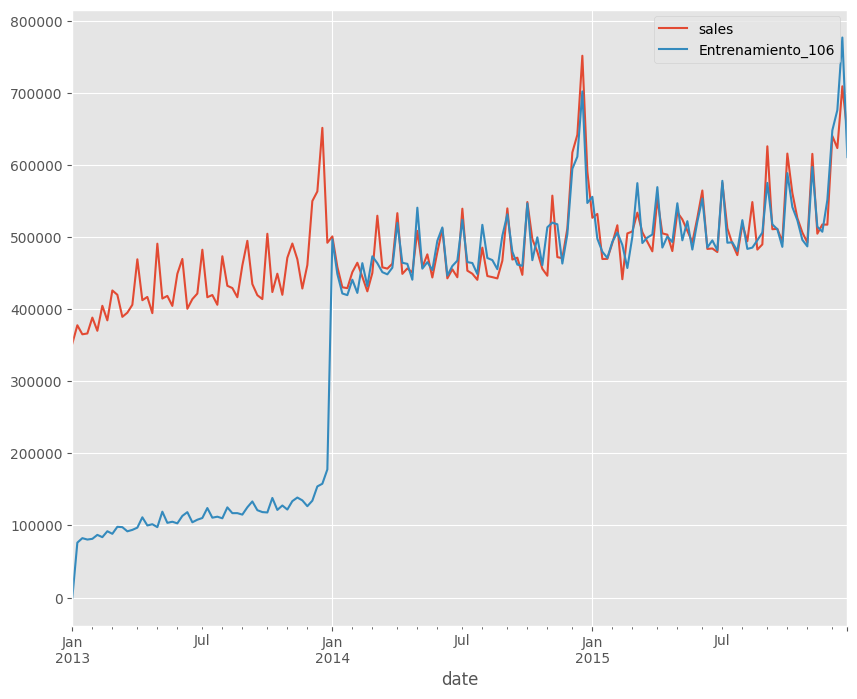

In [ ]:
# Modelo SARIMAX
modelo_106 = sm.tsa.SARIMAX(Train['sales'], order=(2, 0, 1), seasonal_order=(0, 1, 0, 52))
resultados_106 = modelo_106.fit()
Train['Entrenamiento_106'] = resultados_106.fittedvalues
plot = Train[['sales', 'Entrenamiento_106']].plot(figsize=(10, 8))

In [ ]:
# Summary
print(resultados_106.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 52)   Log Likelihood               -1197.644
Date:                             Sat, 18 Nov 2023   AIC                           2403.288
Time:                                     01:00:50   BIC                           2413.865
Sample:                                 01-06-2013   HQIC                          2407.573
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2102      0.084     14.332      0.000       1.045       1.376
ar.L2         -0.2125      

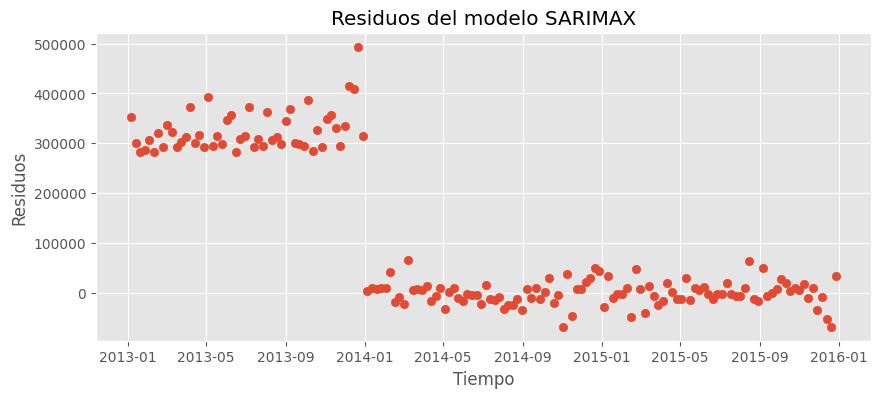

In [ ]:
# Residuales
residuales_106 = resultados_106.resid

# Graficar los residuales
plt.figure(figsize=(10, 4))
plt.scatter(Train.index, residuales_106)
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

In [ ]:
#Resumen de normalidad, p-valor, skewness y curtosis
Normalidad_106 = resultados_106.test_normality('jarquebera')

print("Prueba de normalidad Jarque-Bera:", Normalidad_106[0][0])
print("Prueba de normalidad P-values:", Normalidad_106[0][1])
print("Estadístico de prueba Skewness:", Normalidad_106[0][2])
print("Curtorsis:",Normalidad_106[0][3])

Prueba de normalidad Jarque-Bera: 3.0618733272847165
Prueba de normalidad P-values: 0.21633294118707716
Estadístico de prueba Skewness: 0.016185812887048574
Curtorsis: 3.8399632315137735


In [ ]:
#Pronosticar resultados
forecast_106 = resultados_106.forecast(steps = Test_size+52)
forecast_106

2016-01-03    567068.837811
2016-01-10    569468.703286
2016-01-17    506243.623148
2016-01-24    506207.096910
2016-01-31    527953.499361
                  ...      
2018-07-22    562198.615101
2018-07-29    604569.950111
2018-08-05    580969.110687
2018-08-12    635007.946270
2018-08-19    568851.036685
Freq: W-SUN, Name: predicted_mean, Length: 138, dtype: float64

<Axes: xlabel='date'>

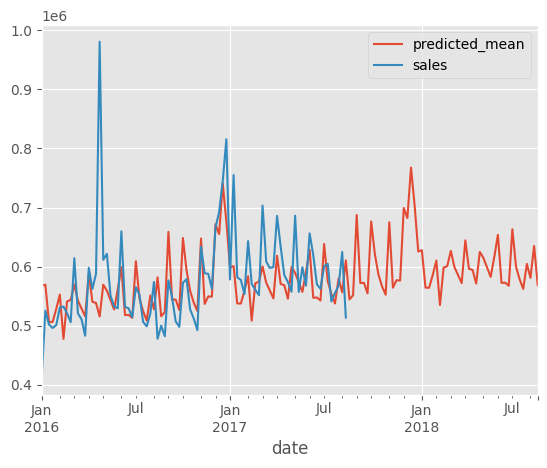

In [ ]:
forecast_106.plot(legend=True)
Test['sales'][:-1].plot(legend=True)

#### Cross Validation, modelo 119

In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_119 = sm.tsa.SARIMAX(Train['sales'], order=(2, 0, 2), seasonal_order=(1, 1, 1, 52)).fit(disp=False)

    predictions = modelo_119.predict(cv_test.index.values[0], cv_test.index.values[-1])

    true_values = cv_test['sales'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions))

print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print("RMLSE promedio: {}".format(np.mean(rmsle))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)
#se demora 5 minutos

RMSE promedio: 55882.088528825574
RMLSE promedio: 0.11252660200923069
RMSE: [29136.452992390423, 19193.034437485865, 41595.3902388699, 97697.31026425475, 54498.432124952196, 93171.9111150003]
RMSLE: [0.05630633164632149, 0.0370719299953777, 0.07869784422955074, 0.14147798871354925, 0.08618649297084018, 0.2754190244997447]


#### Cross Validation, modelo 106

In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_106 = sm.tsa.SARIMAX(Train['sales'], order=(2, 0, 1), seasonal_order=(0, 1, 0, 52)).fit(disp=False)

    predictions = modelo_106.predict(cv_test.index.values[0], cv_test.index.values[-1])

    true_values = cv_test['sales'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions))

print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print("RMLSE promedio: {}".format(np.mean(rmsle))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)
#se demora 5 minutos

RMSE promedio: 56311.87142020126
RMLSE promedio: 0.11298510223142418
RMSE: [30138.304362738298, 19287.314298498346, 41724.24393929772, 98470.32253124735, 55485.0066894961, 92766.03669992971]
RMSLE: [0.0585016538153217, 0.03725832635603132, 0.07922405677468121, 0.14267473468818523, 0.08747854268815085, 0.2727732990661748]
